In [1]:
'''Check that the simulated kappa_gmf values are properly simulated, and also check them as a function of Z'''
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
import matplotlib.lines as mlines

from fancy.interfaces.stan import uv_to_coord
from fancy.plotting.allskymap_cartopy import AllSkyMapCartopy as AllSkyMap

ptypes_list = ["p", "He", "N", "Si", "Fe"]
# ptypes_list = ["p", "He", "N"]
seed = 19990308

# read kappa_gmf values for each particle type

kappa_gmf_list = []
coord_gmf_list = []
coord_defl_list = []

uhecr_coord_list = []
source_coord_list = []

for ptype in ptypes_list:
    sim_output_file = "../../output/{0}_sim_{1}_{2}_{3}_{4}_notightB.h5".format(
        "joint_gmf", "SBG_23", "TA2015", seed, ptype)

    with h5py.File(sim_output_file, "r") as f:
        uhecr_coord_list.append(uv_to_coord(f["uhecr/unit_vector"][()]))
        source_coord_list.append(uv_to_coord(f["source/unit_vector"][()]))

        # print(f["source/distance"][()])
        # print(f["source/label"][()])

        kappa_gmf_list.append(f["uhecr/kappa_gmf"][()])
        coord_gmf_list.append(f["plotvars/omega_rand_kappa_gmf"][()])
        coord_defl_list.append(f["plotvars/omega_defl_kappa_gmf"][()])
        # print(f["uhecr"].keys(), type(uhecr_coord))

        # kappa_gmf

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../../output/joint_gmf_sim_SBG_23_TA2015_19990308_p_notightB.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [24]:
len(kappa_gmf_list[2])

73

<Figure size 504x360 with 0 Axes>

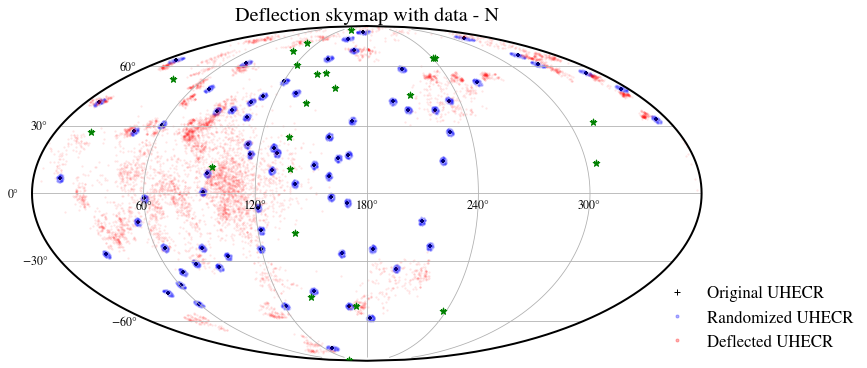

In [25]:
plt.style.use("minimalist")

skymap = AllSkyMap(lon_0 = 180)
skymap.set_gridlines(label_fmt="default")

ptype = "N"

ptype_idx = np.argwhere([p == ptype for p in ptypes_list])[0][0]
# print(ptype_idx)

skymap.scatter(np.rad2deg(np.pi - uhecr_coord_list[ptype_idx].galactic.l.rad), np.rad2deg(uhecr_coord_list[ptype_idx].galactic.b.rad), color="k", alpha=1, marker="+", s=20.0)
skymap.scatter(np.rad2deg(coord_gmf_list[ptype_idx][:, :, 0]), np.rad2deg(coord_gmf_list[ptype_idx][:, :, 1]), color="b", alpha=0.1, s=5.0, lw=0)
skymap.scatter(np.rad2deg(coord_defl_list[ptype_idx][:, :, 0]), np.rad2deg(coord_defl_list[ptype_idx][:, :, 1]), color="r", alpha=0.1, s=5.0, lw=0)
# skymap.scatter(180. - 177.14668051, 49.59823616, color="g", marker="o", s=200)
skymap.scatter(180. - source_coord_list[ptype_idx].galactic.l.deg, source_coord_list[ptype_idx].galactic.b.deg, color="g", alpha=1, marker="*", s=50.0, zorder=10)

handles = [mlines.Line2D([], [], color='k', marker='+', lw=0,
                          markersize=6, alpha=1, label="Original UHECR"),
           mlines.Line2D([], [], color='b', marker='o', lw=0,
                          markersize=3, alpha=0.3, label="Randomized UHECR"),
            mlines.Line2D([], [], color='r', marker='o', lw=0,
                          markersize=3, alpha=0.3, label="Deflected UHECR")]

skymap.legend(handles=handles, bbox_to_anchor=(1.25, 0.27)) 
skymap.title("Deflection skymap with data - {0}".format(ptype))
skymap.save("test.png")



<Figure size 504x360 with 0 Axes>

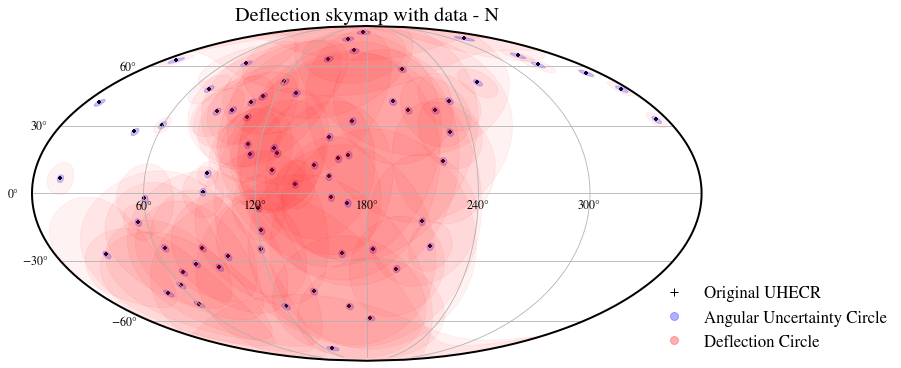

In [26]:
# evaluate dot product between deflected and randomized vector
# then obtain the effective thetea_rms for each (true) UHECR

from astropy.coordinates import SkyCoord
from astropy import units as u

from fancy.interfaces.stan import coord_to_uv
from scipy.optimize import root
ptype = "N"

'''Integral of Fischer distribution used to evaluate kappa_d'''
def fischer_int(kappa, cos_thetaP):
    '''Integral of vMF function over all angles'''
    return (1. - np.exp(-kappa * (1 - cos_thetaP))) / (1. - np.exp(-2.*kappa))

def fischer_int_eq_P(cos_thetaP, kappa, P):
    '''Equation to find roots for'''
    return fischer_int(kappa, cos_thetaP) - P

ptype_idx = np.argwhere([p == ptype for p in ptypes_list])[0][0]
# print(kappa_gmf_list[ptype_idx])

cos_theta_arr = np.zeros(len(kappa_gmf_list[ptype_idx]))
for i, kappa_gmf in enumerate(kappa_gmf_list[ptype_idx]):
    sol = root(fischer_int_eq_P, x0=1, args=(kappa_gmf, 0.683))
    cos_theta = sol.x[0]
    cos_theta_arr[i] = cos_theta

thetas = np.rad2deg(np.arccos(cos_theta_arr))
# print(np.rad2deg(np.arccos(cos_theta_arr)))

skymap = AllSkyMap(lon_0 = 180)
skymap.set_gridlines(label_fmt="default")

ang_err = 1.7
skymap.scatter(np.rad2deg(np.pi - uhecr_coord_list[ptype_idx].galactic.l.rad), np.rad2deg(uhecr_coord_list[ptype_idx].galactic.b.rad), color="k", alpha=1, marker="+", s=10.0)

for i, coord in enumerate(uhecr_coord_list[ptype_idx]):
    lon, lat = 180 - coord.galactic.l.deg, coord.galactic.b.deg
    skymap.tissot(lon, lat, ang_err, color="b", alpha=0.2)
    skymap.tissot(lon, lat, thetas[i], color="r", alpha=0.05)

handles = [mlines.Line2D([], [], color='k', marker='+', lw=0,
                          markersize=8, alpha=1, label="Original UHECR"),
           mlines.Line2D([], [], color='b', marker='o', lw=0,
                          markersize=8, alpha=0.3, label="Angular Uncertainty Circle"),
            mlines.Line2D([], [], color='r', marker='o', lw=0,
                          markersize=8, alpha=0.3, label="Deflection Circle")]

skymap.legend(handles=handles, bbox_to_anchor=(1.3, 0.27)) 
skymap.title("Deflection skymap with data - {0}".format(ptype))

# skymap.scatter(np.rad2deg(coord_true_list[ptype_idx][:, 0]), np.rad2deg(coord_true_list[ptype_idx][:, 1]), color="k", alpha=1, marker="+", s=20.0)
# skymap.scatter(np.rad2deg(coord_rand_list[ptype_idx][:, :, 0]), np.rad2deg(coord_rand_list[ptype_idx][:, :, 1]), color="b", alpha=0.05, s=4.0)


